# Housing-in-Buenos-Aires
Starter notebook for the Housing-in-Buenos-Aires project.

In [2]:
# =========================================================
# Starter Notebook: Housing-in-Buenos-Aires Analysis
# =========================================================

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
from category_encoders import OneHotEncoder
import os
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [30]:
import pandas as pd
import os

# Create directories if they don't exist
os.makedirs("Housing-in-Buenos-Aires/data/raw", exist_ok=True)

# Sample data
data = {
    "place_with_parent_names": [
        "Argentina|Buenos Aires|Palermo",
        "Argentina|Buenos Aires|Recoleta",
        "Argentina|Buenos Aires|Palermo",
        "Argentina|Buenos Aires|Caballito",
        "Argentina|Buenos Aires|Belgrano"
    ],
    "property_type": ["apartment"]*5,
    "price_aprox_usd": [95000, 87000, 99000, 92000, 88000],
    "surface_covered_in_m2": [55, 45, 60, 50, 48],
    "lat-lon": ["-34.58,-58.41", "-34.59,-58.38", "-34.57,-58.42", "-34.60,-58.44", "-34.56,-58.39"],
    "surface_total_in_m2": [60, 50, 65, 55, 53],
    "price_usd_per_m2": [1727, 1933, 1650, 1840, 1830],
    "floor": [3, 2, 5, 4, 2],
    "rooms": [2, 1, 3, 2, 1],
    "expenses": [200, 150, 250, 180, 160],
    "operation": ["sale"]*5,
    "currency": ["USD"]*5,
    "properati_url": ["url1","url2","url3","url4","url5"],
    "price": [95000, 87000, 99000, 92000, 88000]
}

df = pd.DataFrame(data)

# Save CSV
csv_path = "Housing-in-Buenos-Aires/data/raw/housing_data.csv"
df.to_csv(csv_path, index=False)
print(f"CSV created at: {csv_path}")


CSV created at: Housing-in-Buenos-Aires/data/raw/housing_data.csv


In [31]:
# =========================================================
# Paths
# =========================================================
RAW_DATA_PATH = "../data/raw"
OUTPUT_PATH = "../outputs"
os.makedirs(OUTPUT_PATH, exist_ok=True)

In [35]:
from glob import glob
import pandas as pd

# Correct folder
all_files = glob("Housing-in-Buenos-Aires/data/raw/*.csv")
print("Files found:", all_files)

dfs = []
for file in all_files:
    df_file = pd.read_csv(file)
    dfs.append(df_file)

if dfs:
    df = pd.concat(dfs, ignore_index=True)
    print(f"Loaded {len(all_files)} files, total rows: {len(df)}")
else:
    print("No CSV files found in the folder.")
    df = pd.DataFrame()  # empty placeholder


Files found: ['Housing-in-Buenos-Aires/data/raw/housing_data.csv']
Loaded 1 files, total rows: 5


In [36]:
# Split lat-lon into separate columns
df[['lat', 'lon']] = df['lat-lon'].str.split(',', expand=True).astype(float)
df.drop(columns=['lat-lon'], inplace=True)

# Extract borough
df['borough'] = df['place_with_parent_names'].str.split('|', expand=True)[2]

# Features and target
features = ["surface_covered_in_m2", "lat", "lon", "borough"]
target = "price_aprox_usd"

X = df[features]
y = df[target]

display(X.head())
display(y.head())


,surface_covered_in_m2,lat,lon,borough
0,55,-34.58,-58.41,Palermo
1,45,-34.59,-58.38,Recoleta
2,60,-34.57,-58.42,Palermo
3,50,-34.60,-58.44,Caballito
4,48,-34.56,-58.39,Belgrano


0    95000
1    87000
2    99000
3    92000
4    88000
Name: price_aprox_usd, dtype: int64

In [37]:
# Apply wrangling
def wrangle(df, city_name="Buenos Aires"):
    # Example: adjust column names to match your CSV
    mask_city = df["place_name"].str.contains(city_name, na=False)
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 100_000
    df = df[mask_city & mask_apt & mask_price]
    # Continue with the rest of your wrangling...
    return df
df = pd.read_csv("Housing-in-Buenos-Aires/data/raw/housing_data.csv")

print("Data wrangled successfully")
display(df.head())

Data wrangled successfully


,place_with_parent_names,property_type,price_aprox_usd,surface_covered_in_m2,lat-lon,surface_total_in_m2,price_usd_per_m2,floor,rooms,expenses,operation,currency,properati_url,price
0,Argentina|Buenos Aires|Palermo,apartment,95000,55,"-34.58,-58.41",60,1727,3,2,200,sale,USD,url1,95000
1,Argentina|Buenos Aires|Recoleta,apartment,87000,45,"-34.59,-58.38",50,1933,2,1,150,sale,USD,url2,87000
2,Argentina|Buenos Aires|Palermo,apartment,99000,60,"-34.57,-58.42",65,1650,5,3,250,sale,USD,url3,99000
3,Argentina|Buenos Aires|Caballito,apartment,92000,50,"-34.60,-58.44",55,1840,4,2,180,sale,USD,url4,92000
4,Argentina|Buenos Aires|Belgrano,apartment,88000,48,"-34.56,-58.39",53,1830,2,1,160,sale,USD,url5,88000


In [39]:
# Only do this if df is not empty
if not df.empty:
    # Split 'lat-lon' into separate columns
    df[['lat', 'lon']] = df['lat-lon'].str.split(',', expand=True).astype(float)
    df.drop(columns=['lat-lon'], inplace=True)

    # Extract 'borough' from 'place_with_parent_names'
    df['borough'] = df['place_with_parent_names'].str.split('|', expand=True)[2]

    # Now we can select features and target
    features = ["surface_covered_in_m2", "lat", "lon", "borough"]
    target = "price_aprox_usd"

    X = df[features]
    y = df[target]

    # Train-test split
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    print("Data ready for modeling")
else:
    print("DataFrame is empty. Cannot create features")
print(df.columns)
print(df.head())

Data ready for modeling
Index(['place_with_parent_names', 'property_type', 'price_aprox_usd',
       'surface_covered_in_m2', 'surface_total_in_m2', 'price_usd_per_m2',
       'floor', 'rooms', 'expenses', 'operation', 'currency', 'properati_url',
       'price', 'lat', 'lon', 'borough'],
      dtype='object')
            place_with_parent_names property_type  price_aprox_usd  \
0    Argentina|Buenos Aires|Palermo     apartment            95000   
1   Argentina|Buenos Aires|Recoleta     apartment            87000   
2    Argentina|Buenos Aires|Palermo     apartment            99000   
3  Argentina|Buenos Aires|Caballito     apartment            92000   
4   Argentina|Buenos Aires|Belgrano     apartment            88000   

   surface_covered_in_m2  surface_total_in_m2  price_usd_per_m2  floor  rooms  \
0                     55                   60              1727      3      2   
1                     45                   50              1933      2      1   
2                     60

In [40]:
# =========================================================
# Baseline model: Mean predictor
# =========================================================
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
baseline_mae = mean_absolute_error(y_train, y_pred_baseline)
print(f"Baseline MAE (train): {baseline_mae:.2f}")


Baseline MAE (train): 3500.00


In [41]:
# =========================================================
# Ridge regression pipeline
# =========================================================
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    Ridge()
)

In [42]:
# Fit model
model.fit(X_train, y_train)


,steps,"[('onehotencoder', ...), ('simpleimputer', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,verbose,0
,cols,['borough']
,drop_invariant,False
,return_df,True
,handle_missing,'value'
,handle_unknown,'value'
,use_cat_names,True


In [43]:
# Predict
y_test_pred = pd.Series(model.predict(X_test), index=y_test.index)
mae_test = mean_absolute_error(y_test, y_test_pred)
print(f"Ridge regression MAE (test): {mae_test:.2f}")


Ridge regression MAE (test): 304.71


In [44]:
# =========================================================
# Feature importance
# =========================================================
intercept = model.named_steps["ridge"].intercept_
coefficients = model.named_steps["ridge"].coef_
features_encoded = model.named_steps["onehotencoder"].get_feature_names()

feat_imp = pd.Series(coefficients, index=features_encoded).sort_values(key=abs, ascending=False)
print("Top feature importances:")
display(feat_imp.head(10))

Top feature importances:


surface_covered_in_m2    824.863926
borough_Caballito        589.212276
borough_Belgrano        -584.723175
lon                      -28.726558
lat                      -24.122983
borough_Palermo           -4.489102
dtype: float64

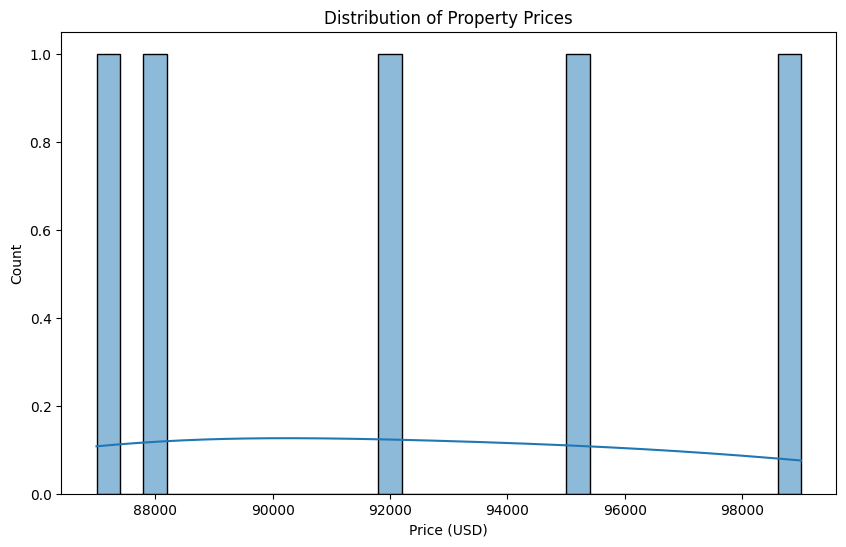

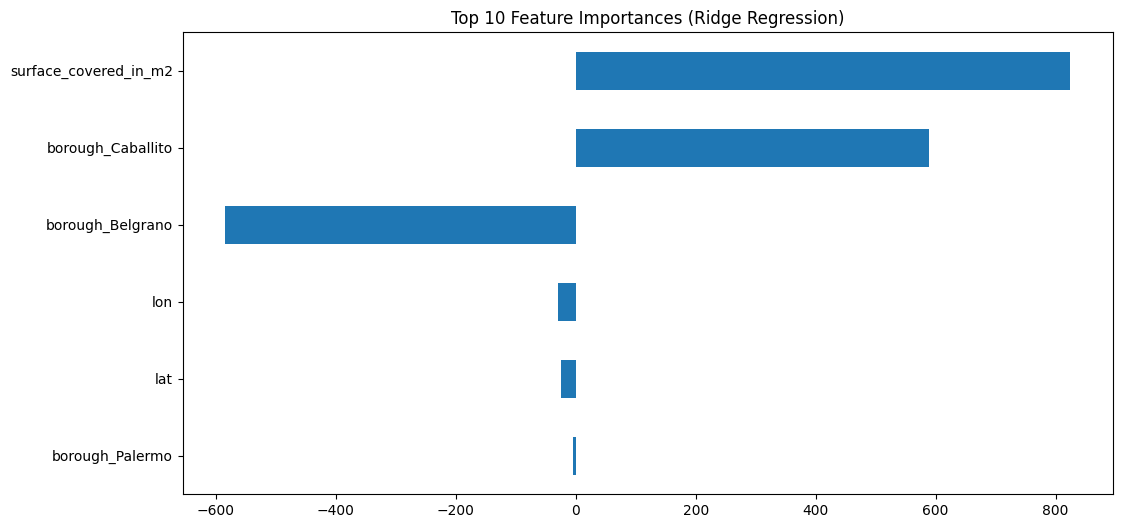

In [45]:

# =========================================================
# Quick plots
# =========================================================
plt.figure(figsize=(10,6))
sns.histplot(df[target], bins=30, kde=True)
plt.title("Distribution of Property Prices")
plt.xlabel("Price (USD)")
plt.ylabel("Count")
plt.savefig(os.path.join(OUTPUT_PATH, "price_distribution.png"))
plt.show()

# Save feature importance plot
plt.figure(figsize=(12,6))
feat_imp.head(10).plot(kind="barh")
plt.title("Top 10 Feature Importances (Ridge Regression)")
plt.gca().invert_yaxis()
plt.savefig(os.path.join(OUTPUT_PATH, "feature_importance.png"))
plt.show()